OpenClassrooms
Project 4, Data Scientist
Author : Oumeima EL GHARBI
Date : August 2022

Un notebook pour chaque prédiction (émissions de CO2 et consommation totale d’énergie) des différents tests de modèles mis au propre, dans lequel vous identifierez clairement le modèle final choisi.


L’objectif est de te passer des relevés de consommation annuels futurs (attention à la fuite de données). Nous ferons de toute façon pour tout nouveau bâtiment un premier relevé de référence la première année, donc rien ne t'interdit d’en déduire des variables structurelles aux bâtiments, par exemple la nature et proportions des sources d’énergie utilisées..

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances de la régression, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée.



Tester les modèles suivants : **regression linéaire (avec différentes régularisation : Ridge, Lasso, Elastic), Random Forest, XGboost**
Penser à comparer les performances des différents modèles : utiliser la **MAE**
Penser également à optimiser les hyper paramètres de chaque modèle via **GridSearch**


Evaluate :

https://cloud.google.com/automl-tables/docs/evaluate?hl=fr


KFOLD

Entrée : données X (dimension nxp), étiquettes y (dimension n), nombre de folds k

Couper [0, 1, ..., n-1] en k parties de taille (n/k). (La dernière partie sera un peu plus petite si n n'est pas un multiple de k)

for i=0 to (k-1):
    Former le jeu de test (X_test, y_test) en restreignant X et y aux indices contenus dans la i-ième partie.
    Former le jeu d'entraînement (X_train, y_train) en restreignant X et y aux autres indices.
    Entraîner l'algorithme sur le jeu d'entraînement
    Utiliser le modèle ainsi obtenu pour prédire sur le jeu de test
        Calculer l'erreur du modèle en comparant les étiquettes prédites aux vraies étiquettes contenues dans y_test

Sortie : la valeur moyenne des erreurs calculées sur les k folds.

In [1455]:
# 1 modele de Regression (RL classsque / Elastic / ridig / laso
# Random Forest
# XGBOOST

# var à rpedire tottal GHE Emssion last one to predict
# cette var deped de la consommation des bateimenst (1) prediction sur elec, steam, naturalgas et un autre energie (2) et reutiliser pour predire

### Introduction

#### Importing libraries

In [1456]:
%reset -f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%autosave 300

Autosaving every 300 seconds


#### Loading dataset

In [1457]:
columns_to_categorize = ["BuildingType", "PrimaryPropertyType", "ZipCode", "CouncilDistrictCode", "LargestPropertyUseType", "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType"]
#  "Neighborhood",
category_types = {column: 'category' for column in columns_to_categorize}
print("This dictionary will be used when reading the csv file to assign a type to categorical features :", category_types)

This dictionary will be used when reading the csv file to assign a type to categorical features : {'BuildingType': 'category', 'PrimaryPropertyType': 'category', 'ZipCode': 'category', 'CouncilDistrictCode': 'category', 'LargestPropertyUseType': 'category', 'SecondLargestPropertyUseType': 'category', 'ThirdLargestPropertyUseType': 'category'}


In [1458]:
dataset_path = "dataset/2016_Building_Energy_Prediction.csv"
# we assign the categorical features with a categotical type
data = pd.read_csv(dataset_path, dtype=category_types, sep=",")

In [1459]:
data.shape

(3157, 23)

In [1460]:
data.dtypes

DataYear                              int64
BuildingType                       category
PrimaryPropertyType                category
ZipCode                            category
CouncilDistrictCode                category
YearBuilt                             int64
NumberofBuildings                   float64
NumberofFloors                        int64
PropertyGFATotal                      int64
PropertyGFAParking                    int64
PropertyGFABuilding(s)                int64
LargestPropertyUseType             category
LargestPropertyUseTypeGFA           float64
SecondLargestPropertyUseType       category
SecondLargestPropertyUseTypeGFA     float64
ThirdLargestPropertyUseType        category
ThirdLargestPropertyUseTypeGFA      float64
ENERGYSTARScore                     float64
SiteEnergyUse(kBtu)                 float64
SteamUse(kBtu)                      float64
Electricity(kBtu)                   float64
NaturalGas(kBtu)                    float64
TotalGHGEmissions               

In [1461]:
# predict : Electricity
# train / test
# standardisation = retirer la moyen et div par ecart type (scaling : les var qn sur emem echelle
# var categ : encoding (one hot encoder)

# la fin Feature engineriing

# 2) entrainer le smodels
# perf
# temps de calcul
# graph pour montrer la perf de chaque modele(barplot)
# obj : finir exploration / finir feature engineering
# obj un premier noteboook propre (try max)

In [1462]:
data.columns

Index(['DataYear', 'BuildingType', 'PrimaryPropertyType', 'ZipCode',
       'CouncilDistrictCode', 'YearBuilt', 'NumberofBuildings',
       'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseType',
       'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseType',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseType',
       'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)', 'Electricity(kBtu)',
       'NaturalGas(kBtu)', 'TotalGHGEmissions'],
      dtype='object')

In [1463]:
features_for_prediction = ["YearBuilt",  "BuildingType","PrimaryPropertyType", "CouncilDistrictCode", "NumberofFloors", "PropertyGFATotal", "PropertyGFAParking", "SecondLargestPropertyUseTypeGFA", "ThirdLargestPropertyUseTypeGFA"]

variable_to_predict = "Electricity(kBtu)"

features_for_prediction.append(variable_to_predict)
print(features_for_prediction)


['YearBuilt', 'BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA', 'Electricity(kBtu)']


In [1464]:
data = data[features_for_prediction]

data

,YearBuilt,BuildingType,PrimaryPropertyType,CouncilDistrictCode,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,Electricity(kBtu)
0,1978,Multifamily LR (1-4),Low-Rise Multifamily,3,3,20739,0,0.0,0.0,8.163010e+05
1,1928,NonResidential,Warehouse,3,2,25955,0,8745.0,3060.0,1.218112e+06
2,1925,Multifamily LR (1-4),Low-Rise Multifamily,2,3,25120,0,0.0,0.0,3.040430e+05
3,1971,Multifamily HR (10+),High-Rise Multifamily,2,15,73898,0,0.0,0.0,2.154352e+06
4,2001,Multifamily LR (1-4),Low-Rise Multifamily,2,3,36383,7030,4200.0,0.0,6.581210e+05
...,...,...,...,...,...,...,...,...,...,...
3152,2001,NonResidential,Mixed Use Property,6,3,41827,9226,14128.0,9680.0,2.439095e+06
3153,1907,Multifamily LR (1-4),Low-Rise Multifamily,6,4,36660,0,0.0,0.0,5.176190e+05
3154,2001,NonResidential,Small- and Mid-Sized Office,6,5,33740,6010,8762.0,1500.0,1.291405e+06
3155,1911,NonResidential,Retail Store,6,2,20516,0,8000.0,0.0,2.649840e+05


## I) Feature Engineering : preparing the vectors and matrices


#### 1) Separating training data and target vector

In [1465]:
# we create the data matrix / we only take the features
X = data[data.columns[:-1]]

# we create the target vector
y = data[variable_to_predict].values # numpy array not a DataFrame anymore

print("Shape of X :", X.shape)
print("Shape of y :", y.shape)

Shape of X : (3157, 9)
Shape of y : (3157,)


In [1466]:
X

,YearBuilt,BuildingType,PrimaryPropertyType,CouncilDistrictCode,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA
0,1978,Multifamily LR (1-4),Low-Rise Multifamily,3,3,20739,0,0.0,0.0
1,1928,NonResidential,Warehouse,3,2,25955,0,8745.0,3060.0
2,1925,Multifamily LR (1-4),Low-Rise Multifamily,2,3,25120,0,0.0,0.0
3,1971,Multifamily HR (10+),High-Rise Multifamily,2,15,73898,0,0.0,0.0
4,2001,Multifamily LR (1-4),Low-Rise Multifamily,2,3,36383,7030,4200.0,0.0
...,...,...,...,...,...,...,...,...,...
3152,2001,NonResidential,Mixed Use Property,6,3,41827,9226,14128.0,9680.0
3153,1907,Multifamily LR (1-4),Low-Rise Multifamily,6,4,36660,0,0.0,0.0
3154,2001,NonResidential,Small- and Mid-Sized Office,6,5,33740,6010,8762.0,1500.0
3155,1911,NonResidential,Retail Store,6,2,20516,0,8000.0,0.0


#### 2) Separation train and test dataset


In [1467]:
print("We have to separate the train / test sets before normalising the dataset.")

We have to separate the train / test sets before normalising the dataset.


In [1468]:
# We create a training set and a test set (the test set contains 30% of the dataset)
from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,  random_state=42)

In [1469]:
X_train.shape

(2209, 9)

In [1470]:
X_test.shape

(948, 9)

#### 3) Normalization

In [1471]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

In [1472]:
print("We separate categorical variables from numerical variables.")

We separate categorical variables from numerical variables.


In [1473]:
X.select_dtypes(['category','object']) # we don't have 'object' here but it is just in case.

categorical_columns = X.select_dtypes(['category','object']).columns
numerical_columns = X.select_dtypes(include='number').columns.drop("YearBuilt")
print("We won't normalise the year so we drop it from numerical_columns.")

print("Shape of categorical variables : ", categorical_columns.shape)
print("Shape of numerical variables :", numerical_columns.shape)

We won't normalise the year so we drop it from numerical_columns.
Shape of categorical variables :  (3,)
Shape of numerical variables : (5,)


##### 1) Data Standardisation

We have to standardize the variables before learning a **Ridge Regression**.
Standardizing means that each variable will have a **standard deviation** equal to 1.

In [1474]:
print("Numerical variables standardization")
print("We have :", numerical_columns.shape[0], "numerical features to standardize.",end="\n\n")

print(numerical_columns)

Numerical variables standardization
We have : 5 numerical features to standardize.

Index(['NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA'],
      dtype='object')


In [1475]:
# We train / fit the scaler on the training set / Computes the mean and std to be used for later scaling.
std_scale = StandardScaler().fit(X_train[numerical_columns])
# We transform the training set and the testing set / Performs standardization by centering and scaling.
X_train_std = X_train.copy()
X_test_std = X_test.copy()

X_train_std[numerical_columns] = std_scale.transform(X_train[numerical_columns])
X_test_std[numerical_columns] = std_scale.transform(X_test[numerical_columns])

print("Before")
display(X_train)
print("After")
display(X_train_std)

Before


,YearBuilt,BuildingType,PrimaryPropertyType,CouncilDistrictCode,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA
748,2001,Multifamily LR (1-4),Low-Rise Multifamily,2,3,121635,0,0.0,0.0
2581,1977,Multifamily LR (1-4),Low-Rise Multifamily,4,3,20383,0,768.0,0.0
662,1966,Multifamily LR (1-4),Low-Rise Multifamily,2,2,21300,0,0.0,0.0
480,1957,NonResidential,Worship Facility,1,2,24224,0,0.0,0.0
803,1908,Multifamily MR (5-9),Mid-Rise Multifamily,7,7,159840,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3092,1985,NonResidential,Large Office,4,5,137738,55504,55504.0,4438.0
1095,2013,Multifamily MR (5-9),Mid-Rise Multifamily,4,6,84577,0,19700.0,0.0
1130,2014,Multifamily MR (5-9),Mid-Rise Multifamily,6,6,292376,0,51663.0,29096.0
1294,1947,Multifamily LR (1-4),Low-Rise Multifamily,6,3,24920,0,0.0,0.0


After


,YearBuilt,BuildingType,PrimaryPropertyType,CouncilDistrictCode,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA
748,2001,Multifamily LR (1-4),Low-Rise Multifamily,2,-0.330868,0.173149,-0.252593,-0.372413,-0.192538
2581,1977,Multifamily LR (1-4),Low-Rise Multifamily,4,-0.330868,-0.465258,-0.252593,-0.353459,-0.192538
662,1966,Multifamily LR (1-4),Low-Rise Multifamily,2,-0.509613,-0.459476,-0.252593,-0.372413,-0.192538
480,1957,NonResidential,Worship Facility,1,-0.509613,-0.441040,-0.252593,-0.372413,-0.192538
803,1908,Multifamily MR (5-9),Mid-Rise Multifamily,7,0.384111,0.414037,-0.252593,-0.372413,-0.192538
...,...,...,...,...,...,...,...,...,...
3092,1985,NonResidential,Large Office,4,0.026622,0.274681,1.314047,0.997429,0.200441
1095,2013,Multifamily MR (5-9),Mid-Rise Multifamily,4,0.205366,-0.060506,-0.252593,0.113784,-0.192538
1130,2014,Multifamily MR (5-9),Mid-Rise Multifamily,6,0.205366,1.249695,-0.252593,0.902633,2.383877
1294,1947,Multifamily LR (1-4),Low-Rise Multifamily,6,-0.330868,-0.436652,-0.252593,-0.372413,-0.192538


We can check that the numerical variables have a Standard Normal distribution.


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdep

IMPORT FUNCTIONS / DENSITE


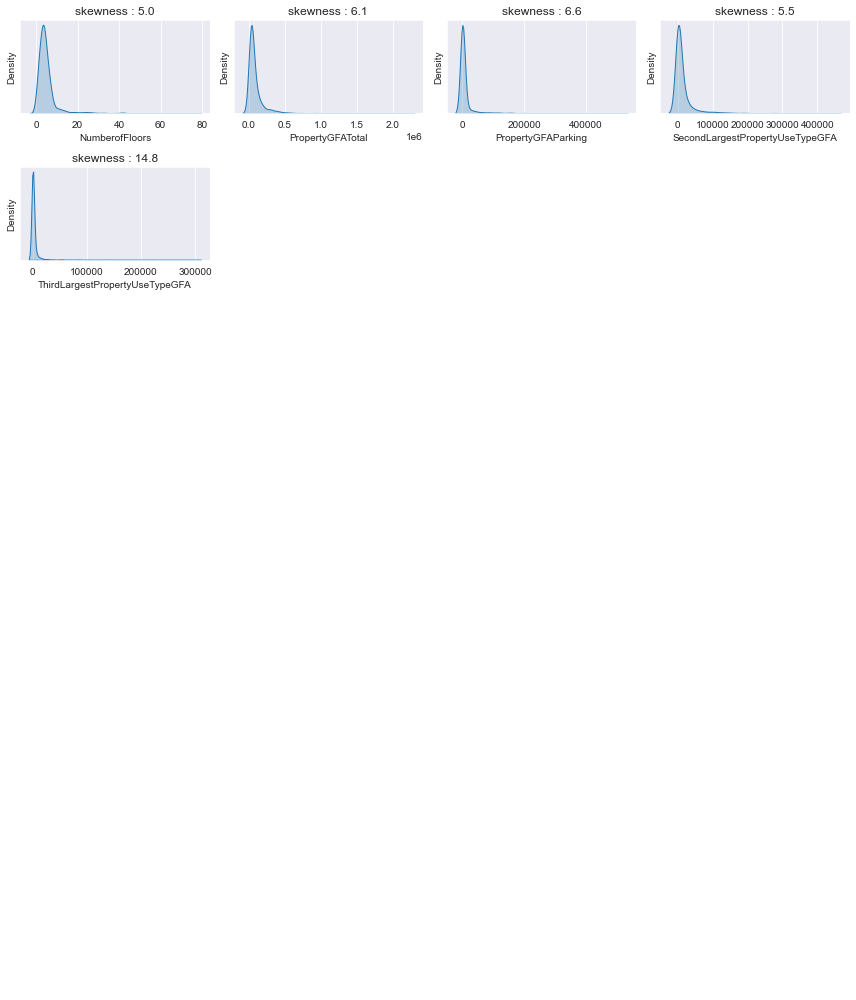

In [1476]:
def densite(df, lines=7, cols=4):
    """
    Input : dataframe, lignes, colonnes
    Output : grille des courbes de densités des variables numériques du dataframe
    """
    df = df.select_dtypes(include='number').copy()

    fig, ax = plt.subplots(lines, cols, figsize=(min(15, cols * 3), lines * 2))

    for i, val in enumerate(df.columns.tolist()):
        bp = sns.distplot(df[val], hist=False, ax=ax[i // cols, i % cols], kde_kws={'shade': True})
        bp.set_title("skewness : " + str(round(df[val].skew(), 1)), fontsize=12)
        bp.set_yticks([])
        imax = i

    for i in range(imax + 1, lines * cols):
        ax[i // cols, i % cols].axis('off')

    plt.tight_layout()

print("We can check that the numerical variables have a Standard Normal distribution.")
densite(X_train[numerical_columns])

print("IMPORT FUNCTIONS / DENSITE")

##### 2) Feature Encoding : One Hot Encoder

In [1477]:
print("Categorical variables featuring")

print("We have :", categorical_columns.shape[0], "categorical features to encode.", end="\n\n")
print(categorical_columns)

Categorical variables featuring
We have : 3 categorical features to encode.

Index(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode'], dtype='object')


In [1478]:
X.dtypes # we check that we have categories

YearBuilt                             int64
BuildingType                       category
PrimaryPropertyType                category
CouncilDistrictCode                category
NumberofFloors                        int64
PropertyGFATotal                      int64
PropertyGFAParking                    int64
SecondLargestPropertyUseTypeGFA     float64
ThirdLargestPropertyUseTypeGFA      float64
dtype: object

In [1479]:
X[categorical_columns].nunique()

BuildingType            8
PrimaryPropertyType    23
CouncilDistrictCode     7
dtype: int64

In [1480]:
X_train_std[categorical_columns]

,BuildingType,PrimaryPropertyType,CouncilDistrictCode
748,Multifamily LR (1-4),Low-Rise Multifamily,2
2581,Multifamily LR (1-4),Low-Rise Multifamily,4
662,Multifamily LR (1-4),Low-Rise Multifamily,2
480,NonResidential,Worship Facility,1
803,Multifamily MR (5-9),Mid-Rise Multifamily,7
...,...,...,...
3092,NonResidential,Large Office,4
1095,Multifamily MR (5-9),Mid-Rise Multifamily,4
1130,Multifamily MR (5-9),Mid-Rise Multifamily,6
1294,Multifamily LR (1-4),Low-Rise Multifamily,6


In [1481]:
print("Now, we can use the One Hot Encoder.")
print("With the one hot encoder, we will get :", sum([X[categorical_columns].nunique()[i] for i in range(len(categorical_columns))]), "columns to encodes the categorical features.")

# creating instance of one-hot-encoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False) # if sparse=True (by default), we need to add .toarray() to encoded_categorical_data

# 1) Fit the encoder on the training set
one_hot_encoder.fit(X_train_std[categorical_columns])
# 2) we get the encoded numpy array
encoded_categorical_data = one_hot_encoder.transform(X_train_std[categorical_columns])
# 3) we make a list of the columns names
encoded_categorical_data_names = one_hot_encoder.get_feature_names_out().tolist()

print("We have indeed :", len(encoded_categorical_data_names), "labels after encoding the categorical variables.")

# 4) we recreate a dataframe with the column names and the numpy array
X_train_encoded = pd.DataFrame(columns=encoded_categorical_data_names,
                               data=encoded_categorical_data,
                               index=X_train_std.index)
display(X_train_encoded)

Now, we can use the One Hot Encoder.
With the one hot encoder, we will get : 38 columns to encodes the categorical features.
We have indeed : 38 labels after encoding the categorical variables.


,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,BuildingType_SPS-District K-12,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_High-Rise Multifamily,...,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,CouncilDistrictCode_1,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7
748,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2581,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
662,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
480,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
803,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1095,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1130,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1294,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [1482]:
numerical_columns.tolist()

['NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA']

In [1483]:
features_to_merge = numerical_columns.tolist().copy()
features_to_merge.append("YearBuilt")
features_to_merge

['NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'SecondLargestPropertyUseTypeGFA',
 'ThirdLargestPropertyUseTypeGFA',
 'YearBuilt']

In [1484]:
X_train_encoded

,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),BuildingType_NonResidential,BuildingType_Nonresidential COS,BuildingType_Nonresidential WA,BuildingType_SPS-District K-12,PrimaryPropertyType_Distribution Center,PrimaryPropertyType_High-Rise Multifamily,...,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,CouncilDistrictCode_1,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7
748,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2581,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
662,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
480,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
803,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1095,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1130,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1294,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [1485]:
X_train_std[features_to_merge].sort_index()

,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,YearBuilt
1,-0.509613,-0.430126,-0.252593,-0.156586,0.078421,1928
2,-0.330868,-0.435391,-0.252593,-0.372413,-0.192538,1925
3,1.814069,-0.127839,-0.252593,-0.372413,-0.192538,1971
4,-0.330868,-0.364376,-0.054166,-0.268757,-0.192538,2001
5,-0.152123,-0.348134,-0.252593,-0.372413,-0.192538,1996
...,...,...,...,...,...,...
3148,-0.330868,-0.398499,-0.252593,-0.372413,-0.192538,1920
3149,-0.330868,-0.450857,-0.252593,-0.372413,-0.192538,1946
3151,-0.509613,-0.380410,-0.252593,-0.035283,-0.065028,1927
3154,0.026622,-0.381040,-0.082956,-0.156166,-0.059715,2001


In [1486]:
X_try = pd.merge(X_train_std[features_to_merge].sort_index(), X_train_encoded.sort_index(), left_index=True, right_index=True)
#Concatenate the two dataframes :
data_out = pd.concat([X_train_std[features_to_merge], X_train_encoded], axis=1)
display(data_out)

,NumberofFloors,PropertyGFATotal,PropertyGFAParking,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,YearBuilt,BuildingType_Campus,BuildingType_Multifamily HR (10+),BuildingType_Multifamily LR (1-4),BuildingType_Multifamily MR (5-9),...,PrimaryPropertyType_University,PrimaryPropertyType_Warehouse,PrimaryPropertyType_Worship Facility,CouncilDistrictCode_1,CouncilDistrictCode_2,CouncilDistrictCode_3,CouncilDistrictCode_4,CouncilDistrictCode_5,CouncilDistrictCode_6,CouncilDistrictCode_7
748,-0.330868,0.173149,-0.252593,-0.372413,-0.192538,2001,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2581,-0.330868,-0.465258,-0.252593,-0.353459,-0.192538,1977,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
662,-0.509613,-0.459476,-0.252593,-0.372413,-0.192538,1966,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
480,-0.509613,-0.441040,-0.252593,-0.372413,-0.192538,1957,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
803,0.384111,0.414037,-0.252593,-0.372413,-0.192538,1908,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,0.026622,0.274681,1.314047,0.997429,0.200441,1985,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1095,0.205366,-0.060506,-0.252593,0.113784,-0.192538,2013,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1130,0.205366,1.249695,-0.252593,0.902633,2.383877,2014,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1294,-0.330868,-0.436652,-0.252593,-0.372413,-0.192538,1947,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## II) Modelisation

In [1487]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

### 1) Linear modelisation : Linear Regression / Ridge Regression / Lasso / Elastic Net


In [1488]:
X_train.shape

(2209, 9)

In [1489]:
X_test.shape

(948, 9)

#### 1) Linear Regression : baseline

In [1490]:
from sklearn import linear_model

# On crée un modèle de régression linéaire
lr = linear_model.LinearRegression()
# On entraîne ce modèle sur les données d'entrainement
lr.fit(X_train, y_train)

ValueError: could not convert string to float: 'Multifamily LR (1-4)'

In [ ]:
# On récupère l'erreur de norme 2 sur le jeu de données test comme baseline
baseline_error = np.mean((lr.predict(X_test) - y_test) ** 2)

#On obtient l'erreur quadratique ci-dessous
print(baseline_error)

#### 2) Linear Regression : Ridge

In [ ]:
n_alphas = 50 #hyperparametre alpha
alphas = np.logspace(-5, 5, 50)

ridge = linear_model.Ridge()

coefs = []
errors = []
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_train)
    coefs.append(ridge.coef_)
    errors.append(np.mean((ridge.predict(X_test) - y_test) ** 2))

In [ ]:
# observation du comportement de l'erreur

ax = plt.gca()
ax.plot(alphas, errors, [10**-5, 10**5], [baseline_error, baseline_error])
ax.set_xscale('log')
plt.show()

In [ ]:
ax = plt.gca()

ax.plot(alphas, errors)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('error')
plt.axis('tight')
plt.show()

In [ ]:
# index du min des erreurs
np.argmin(errors)

In [ ]:
# recupere l'erreur min
errors[np.argmin(errors)]

In [ ]:
# recup alpha associé à cet erreur min
alphas[np.argmin(errors)]
# alphas[35]

In [ ]:
# chemin de régularisation
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.show()

In [ ]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [ ]:
min(errors)

#### 3) Linear Regression : LASSO

In [ ]:
n_alphas = 50
alphas = np.logspace(-5, 5, 50)

lasso = linear_model.Lasso()

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train)
    coefs.append(lasso.coef_)
    errors.append(np.mean((lasso.predict(X_test) - y_test) ** 2))

In [ ]:
n_alphas = 300
alphas = np.logspace(-5, 1, n_alphas)
lasso = linear_model.Lasso(fit_intercept=False)

"""
fit_intercept : bool, default=True
Whether to calculate the intercept for this model. If set to False, no intercept will be used in calculations (i.e. data is expected to be centered).
"""

coefs = []
errors = []
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    errors.append([baseline_error, np.mean((lasso.predict(X_test) - y_test) ** 2)])

In [ ]:
# observation du comportement de l'erreur

ax = plt.gca()
ax.plot(alphas, errors, [10**-5, 10**5], [baseline_error, baseline_error])
ax.set_xscale('log')
plt.show()

In [ ]:
# recupere l'erreur min
errors[np.argmin(errors)]

In [ ]:
# recup alpha associé à cet erreur min
alphas[np.argmin(errors)]

In [ ]:
# chemin de régularisation
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.show()

In [ ]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.axis('tight')
plt.show()

In [ ]:
import numpy as np

X = np.matrix([-0.78768, -1.51760513, 0.74416271, -0.62288928])
X = X.T
print(X)

y = np.matrix([-34.59703199, -30.79543532, 19.31018182, -19.44809959])
y = y.T
print(y)
print(np.linalg.inv(X.T.dot(X)).dot(X.T))
beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
beta

#### Export des modèles pour réutilisation ultérieure


#### Chargement des modèles


#### Comparaison des modèles


### III) Evaluation

#### Vérification des prédictions


#### Intérêt du Energy Star Score
